## Predict student gender based on their tastes

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Permutation Feature Importance
import eli5
from eli5.sklearn import PermutationImportance

import graphviz

In [4]:
# improve how pandas numbers are displayed
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

np.set_printoptions(suppress=True)

In [5]:
def score_prediction(y_test, y_pred, model=None, columns=None):
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred):.3f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.3f}')
    print(f'F1:        {f1_score(y_test, y_pred):.3f}')
    if model:
        print(F'\nCoefficients:\n{pd.Series(model.coef_[0], index=columns)}')
    
    
def corr_plot(mat, title='My Title', color='cividis'):
    plt.subplots(figsize=(14, 11))
    plt.title(title,fontsize=22)

    sns.heatmap(mat,linewidths=0.2,vmax=0.7,square=True,cmap=color, 
                linecolor='w',annot=True,annot_kws={'size':9},cbar_kws={'shrink': .5})

def _tpr(y_actual, y_pred):
    tn, fn, fp, tp = _confusion_matrix(y_actual, y_pred)
    return tp / (tp + fn)

def _fpr(y_actual, y_pred):
    tn, fn, fp, tp = _confusion_matrix(y_actual, y_pred)
    return fp / (fp + tn)

def _roc(y_actual, y_pred):
    tpr = _tpr(y_actual, y_pred)
    fpr = _fpr(y_actual, y_pred)
    return tpr, fpr

def tpr_thresh(thresh):
    y_pred = (y_pred_prob > thresh).astype('int')
    return _tpr(y_test, y_pred)

def fpr_thresh(thresh):
    y_pred = (y_pred_prob > thresh).astype('int')
    return _fpr(y_test, y_pred)

def _confusion_matrix(y_actual, y_pred, if_print=False):
    tp, tn, fp, fn = 0, 0, 0, 0
    for (actual, predicted) in zip(y_test, y_pred):
        if actual == predicted :
            if predicted:
                tp += 1
            else:
                tn += 1
        else:
            if predicted:
                fp += 1
            else:
                fn += 1
    if if_print:
        print('                    ------ Actuals -----')
        print('                      False  |   True   ')
        print('                    --------------------') 
        print(f'Predicted - False | {tn: >5.0f}    |  {fn: >5.0f}')
        print(f'            True  | {fp: >5.0f}    |  {tp: >5.0f}')
     
    return tn, fn, fp, tp

In [6]:
df = pd.read_csv('https://github.com/giedriusblazys/SDA_DS_class/raw/main/practice/input/student_gender.csv')

In [7]:
df.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


In [8]:
df.isna().sum()

Favorite Color          0
Favorite Music Genre    0
Favorite Beverage       0
Favorite Soft Drink     0
Gender                  0
dtype: int64

In [9]:
df['if_female'] = (df.Gender=='F').astype('int')

In [10]:
df['Favorite Color'].value_counts()

Cool       37
Warm       22
Neutral     7
Name: Favorite Color, dtype: int64

In [11]:
target = 'if_female'

print(f"Object type features: {df.columns[df.dtypes=='object']}")
print(f"Numeric type features: {df.columns[df.dtypes!='object']}")

Object type features: Index(['Favorite Color', 'Favorite Music Genre', 'Favorite Beverage',
       'Favorite Soft Drink', 'Gender'],
      dtype='object')
Numeric type features: Index(['if_female'], dtype='object')


In [12]:
y = df[target]
x = df.drop(columns=[target, 'Gender'])

X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=40, stratify=y)
print(X_train.shape, X_test.shape)
print(f'Ratio of females in train dataset: {y_train.mean()}, in test dataset: {y_test.mean()}')

(46, 4) (20, 4)
Ratio of females in train dataset: 0.5, in test dataset: 0.5


#### Try categorical variable encoding

In [13]:
s = (X_train.dtypes == 'object')
obj_cols = list(s[s].index)

##### One-hot encoder

In [14]:
OH_encoder = preprocessing.OneHotEncoder(drop='first')

In [15]:
X_train_array = OH_encoder.fit_transform(X_train[obj_cols]).toarray()
OH_cols_train = pd.DataFrame(X_train_array, columns = OH_encoder.get_feature_names_out())
X_test_array = OH_encoder.transform(X_test[obj_cols]).toarray()
OH_cols_test = pd.DataFrame(X_test_array, columns = OH_encoder.get_feature_names_out())
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(obj_cols, axis=1)
num_X_test = X_test.drop(obj_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
OH_X_train.head()

,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Doesn't drink,Favorite Beverage_Other,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other
41,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
55,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
33,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
27,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
50,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [16]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=3).fit(OH_X_train, y_train)
y_pred = tree_model.predict(OH_X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.400
Precision: 0.400
Recall:    0.400
F1:        0.400


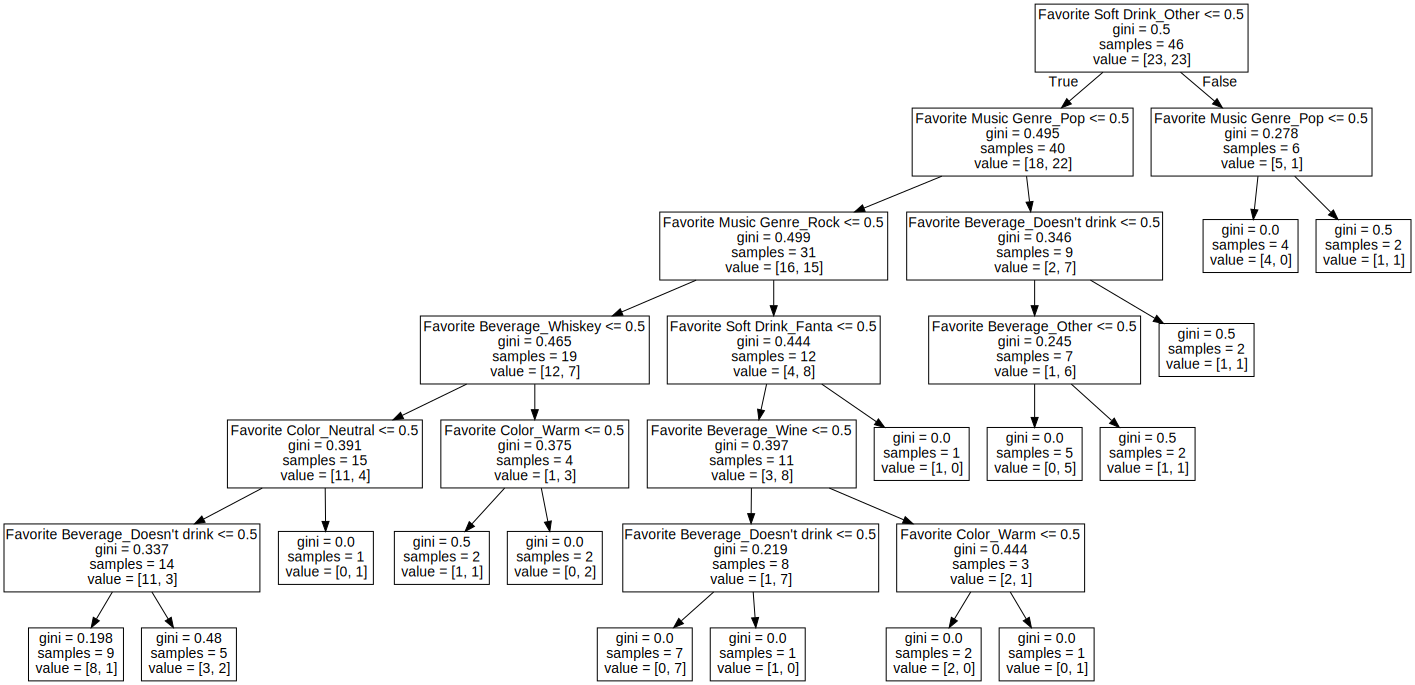

In [17]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=OH_X_train.columns)
graphviz.Source(tree_graph)

In [18]:
logit_model = LogisticRegression(penalty='l2', C=2).fit(OH_X_train, y_train)
y_pred = logit_model.predict(OH_X_test)
score_prediction(y_test, y_pred, model=logit_model, columns=OH_X_train.columns)

Accuracy:  0.550
Precision: 0.533
Recall:    0.800
F1:        0.640

Coefficients:
Favorite Color_Neutral                   0.0307
Favorite Color_Warm                      0.4367
Favorite Music Genre_Folk/Traditional   -0.0986
Favorite Music Genre_Hip hop            -0.7369
Favorite Music Genre_Jazz/Blues          0.2082
Favorite Music Genre_Pop                 1.3797
Favorite Music Genre_R&B and soul       -0.8770
Favorite Music Genre_Rock                0.6404
Favorite Beverage_Doesn't drink         -0.1516
Favorite Beverage_Other                 -0.2011
Favorite Beverage_Vodka                  0.9493
Favorite Beverage_Whiskey                0.8261
Favorite Beverage_Wine                  -0.0328
Favorite Soft Drink_Coca Cola/Pepsi      0.1704
Favorite Soft Drink_Fanta               -0.1787
Favorite Soft Drink_Other               -1.1395
dtype: float64


In [19]:
logit_model = LogisticRegression(penalty='l1', C=1, solver='liblinear').fit(OH_X_train, y_train)
y_pred = logit_model.predict(OH_X_test)
score_prediction(y_test, y_pred, model=logit_model, columns=OH_X_train.columns)

Accuracy:  0.500
Precision: 0.500
Recall:    0.600
F1:        0.545

Coefficients:
Favorite Color_Neutral                   0.0000
Favorite Color_Warm                      0.0000
Favorite Music Genre_Folk/Traditional    0.0000
Favorite Music Genre_Hip hop            -0.3110
Favorite Music Genre_Jazz/Blues          0.0000
Favorite Music Genre_Pop                 0.7633
Favorite Music Genre_R&B and soul       -0.1934
Favorite Music Genre_Rock                0.1525
Favorite Beverage_Doesn't drink         -0.1381
Favorite Beverage_Other                  0.0000
Favorite Beverage_Vodka                  0.3789
Favorite Beverage_Whiskey                0.0000
Favorite Beverage_Wine                   0.0000
Favorite Soft Drink_Coca Cola/Pepsi      0.0000
Favorite Soft Drink_Fanta                0.0000
Favorite Soft Drink_Other               -0.8492
dtype: float64


##### Ordinal Encoder

In [20]:
ordinal_enc = preprocessing.OrdinalEncoder()

label_cols_train = pd.DataFrame(ordinal_enc.fit_transform(X_train[obj_cols]), columns = X_train[obj_cols].columns)
label_cols_test = pd.DataFrame(ordinal_enc.transform(X_test[obj_cols]), columns = X_test[obj_cols].columns)
label_cols_train.index = X_train.index
label_cols_test.index = X_test.index

# Remove categorical columns (will replace with encoded values)
num_X_train = X_train.drop(obj_cols, axis=1)
num_X_test = X_test.drop(obj_cols, axis=1)

# Add encoded columns to numerical features
label_X_train = pd.concat([num_X_train, label_cols_train], axis=1)
label_X_test = pd.concat([num_X_test, label_cols_test], axis=1)
label_X_train.head()


,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink
41,1.0000,4.0000,1.0000,0.0000
55,0.0000,0.0000,2.0000,2.0000
33,2.0000,5.0000,5.0000,3.0000
27,0.0000,4.0000,1.0000,3.0000
50,0.0000,5.0000,1.0000,1.0000


In [21]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=3).fit(label_X_train, y_train)
y_pred = tree_model.predict(label_X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.550
Precision: 0.545
Recall:    0.600
F1:        0.571


RANDOMS SEED 412
Accuracy:  0.600
Precision: 0.700
Recall:    0.583
F1:        0.636

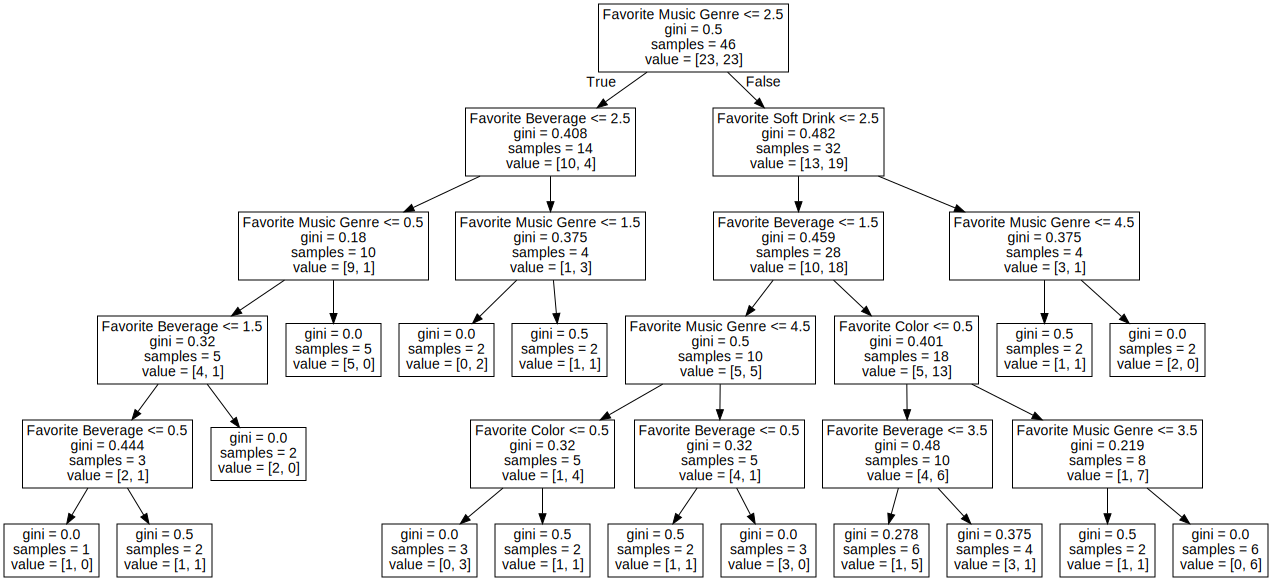

In [22]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=label_X_train.columns)
graphviz.Source(tree_graph)

In [23]:
# Label (ordinal) encoding should not be used with logistic regression
logit_model = LogisticRegression(penalty='l2', C=2).fit(label_X_train, y_train)
y_pred = logit_model.predict(label_X_test)
score_prediction(y_test, y_pred, model=logit_model, columns=label_X_train.columns)

Accuracy:  0.550
Precision: 0.545
Recall:    0.600
F1:        0.571

Coefficients:
Favorite Color          0.1370
Favorite Music Genre    0.1440
Favorite Beverage       0.1266
Favorite Soft Drink    -0.4644
dtype: float64


### HW 4
Test the stability of your favorite model with different Random State (Seed) on K Fold validation (how results change as you increase number of folds - try leave-one-out validation as the extreme case). Use stratified option - StratifiedKFold, LeaveOneOut